<a href="https://colab.research.google.com/github/fasthill/ML-DL-study-alone/blob/main/9-2%20%EC%88%9C%ED%99%98%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9C%BC%EB%A1%9C%20IMDB%20%EB%A6%AC%EB%B7%B0%20%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

## IMDB 리뷰 데이터셋

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

In [3]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [4]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


1: 샘플 문장의 시작 부분을 나타낼 때 사용, 2: 선택된 500개 단어에 포함되어 있지 않은 단어

train_input: [ [리뷰1], [리뷰2], [리뷰3] ] numpy 배열로 원소는 리스트로 구성됨.

In [5]:
print(train_target[:20])  # 긍정일 때 :1, 부정일 때: 0

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


### 훈련 세트 준비

In [6]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

train-input의 리스트로 구성된 각 원소의 길이를 리스트로 구하고, array로 구성

In [7]:
train_input.shape

(20000,)

In [8]:
print(len(train_input[0]))  # 각 개의 요소의 길이가 다름 (문장의 길이가 다름, 토큰의 갯수가 다름)

259


In [9]:
print(len(train_input[1])) # 각 개의 요소의 길이가 다름 (문장의 길이가 다름, 토큰의 갯수가 다름)

520


문장 길이의 분포를 확인

In [10]:
lengths = np.array([len(x) for x in train_input])

In [11]:
lengths.shape, lengths[:20]

((20000,),
 array([259, 520, 290, 109, 559,  96, 130, 935, 383, 716, 195,  55, 122,
        142, 104, 109, 179, 777, 368, 311]))

In [12]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


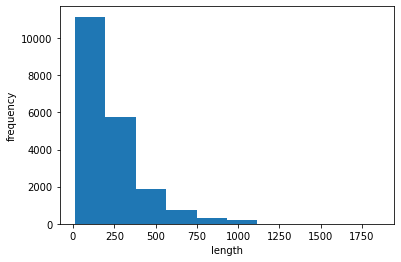

In [13]:
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [14]:
max_words = max([max(elem) for elem in train_input])
max_length = max([len(elem) for elem in train_input])

In [15]:
max_words, max_length   # 최대 단어 갯수, 최대 문장 길이

(499, 1854)

### Sequence Padding

In [16]:
train_seq = pad_sequences(train_input, maxlen=100) # 100개의 토큰 크기로 제한, 적으면 0으로 패딩, 크면 잘라내기

padding='pre', truncate='pre' arg가 default로 뒷쪽에서 부터 100개를 선정하여 취하고(앞쪽을 자르고), 100개에 부족하면, 앞쪽에 0을 삽입함.

In [17]:
print(train_seq.shape)

(20000, 100)


In [18]:
train_seq

array([[ 10,   4,  20, ...,  10, 470, 158],
       [206,   2,  26, ...,   6,   2,   2],
       [  2,   7,   2, ...,   2,   2,  12],
       ...,
       [  2,  37, 299, ...,   7,  14,   2],
       [  0,   0,   0, ...,  25, 170,   2],
       [  0,   0,   0, ...,  25, 194,   2]], dtype=int32)

In [19]:
print(train_input[0][-10:])
print(train_seq[0, -10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]
[  6   2  46   7  14  20  10  10 470 158]


In [20]:
print(train_seq[0]) # 뒤에서부터 100개의 단어(토큰)가 저장됨.

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [21]:
print(train_seq[5]) # 뒤에서 부터 채워져서 100개에 부족한 부분은 0으로 채워짐.

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [22]:
val_seq = pad_sequences(val_input, maxlen=100) # 100개의 토큰 크기로 제한, 적으면 0으로 패딩, 크면 잘라내기

In [23]:
val_seq

array([[ 32,   2, 225, ...,  14,  58,   2],
       [ 53,   2,   8, ...,   7,  32,   2],
       [  0,   0,   0, ...,   2,  33,  32],
       ...,
       [383,   2, 120, ...,  16,  99,  76],
       [106, 345,  12, ..., 120,   2, 156],
       [  4, 114,  21, ...,   4,   2,   2]], dtype=int32)

## 순환 신경망 만들기

In [24]:
model = Sequential()
model.add(SimpleRNN(8, input_shape=(100, 500)))
model.add(Dense(1, activation='sigmoid'))

In [25]:
train_oh = to_categorical(train_seq)
val_oh = to_categorical(val_seq)

In [26]:
train_oh.shape, val_oh.shape

((20000, 100, 500), (5000, 100, 500))

In [27]:
print(train_oh[0][0][:12]) # == print(train_oh[0, 0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [28]:
print(np.sum(train_oh[0][0]))

1.0


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


4072 = 8개 뉴런 × 500개 one hot encoding 배열 + 8개 순환입력 × 8개 노드 + 8개 절편

## 순환 신경망 훈련하기

In [30]:
rmsprop = RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
checkpoint_cb = ModelCheckpoint('best_simplernn_model.h5')
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

In [32]:
history = model.fit(train_oh, train_target,
          validation_data=[val_oh, val_target],
          callbacks=[checkpoint_cb, early_stopping_cb],
          epochs=100, batch_size=64)

Epoch 1/100
313/313 [==============================] - 20s 54ms/step - loss: 0.6983 - accuracy: 0.5026 - val_loss: 0.6964 - val_accuracy: 0.5044
Epoch 2/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6948 - accuracy: 0.5108 - val_loss: 0.6940 - val_accuracy: 0.5160
Epoch 3/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6918 - accuracy: 0.5203 - val_loss: 0.6919 - val_accuracy: 0.5260
Epoch 4/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6891 - accuracy: 0.5343 - val_loss: 0.6897 - val_accuracy: 0.5336
Epoch 5/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6862 - accuracy: 0.5473 - val_loss: 0.6870 - val_accuracy: 0.5508
Epoch 6/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6826 - accuracy: 0.5594 - val_loss: 0.6833 - val_accuracy: 0.5642
Epoch 7/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6765 - accuracy: 0.5841 - val_loss: 0.6746 - val_ac

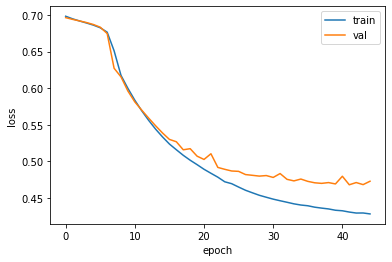

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기

In [34]:
model2 = Sequential()

In [35]:
model2.add(Embedding(500, 16, input_length=100))  # 16개의 실수 벡터로 출력
model2.add(SimpleRNN(8))
model2.add(Dense(1, activation='sigmoid'))

In [36]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


8000 = 500 \* 16, 200 = 16 \* 8 + 8 \* 8 (8개노드 순환입력) + 8

In [39]:
rmsprop = RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

In [40]:
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 24ms/step - loss: 0.6793 - accuracy: 0.5651 - val_loss: 0.6437 - val_accuracy: 0.6486
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6132 - accuracy: 0.6912 - val_loss: 0.5951 - val_accuracy: 0.7092
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5778 - accuracy: 0.7314 - val_loss: 0.5758 - val_accuracy: 0.7344
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5575 - accuracy: 0.7487 - val_loss: 0.5567 - val_accuracy: 0.7510
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5410 - accuracy: 0.7643 - val_loss: 0.5460 - val_accuracy: 0.7558
Epoch 6/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5283 - accuracy: 0.7716 - val_loss: 0.5378 - val_accuracy: 0.7578
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5153 - accuracy: 0.7786 - val_loss: 0.5242 - val_accuracy

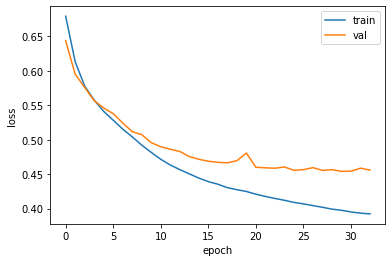

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()